In [27]:
from functools import partial

import jax
import jax.numpy as jnp
from jax.tree_util import Partial

jax.config.update("jax_enable_x64", True)


def RBFKernel(sigma_f, length, x, y):
    return (
            sigma_f * jnp.exp(-(jnp.linalg.norm(x - y) ** 2) / (2 * length ** 2))
    ).astype(float)


def ExpSineSquaredKernel(sigma_f: float, length: float, periodictiy: float, x, y):
    def euclidian(x, y):
        return jnp.sqrt(jnp.sum((x - y) ** 2))

    return (
            sigma_f
            * jnp.exp(-2 * (jnp.sin(jnp.pi * euclidian(x, y) / periodictiy) / length) ** 2)
    ).astype(float)


# Helper function to calculate the respective covariance matrices
@jax.jit
def cov_matrix(x1, x2, cov_function):
    return jax.vmap(lambda x_: jax.vmap(lambda y_: cov_function(x_, y_))(x1))(x2)


@partial(jax.jit, static_argnames=["kernel_"])
def log_likelihood(kernel_, params, data_x, data_y, eps):
    K = cov_matrix(data_x, data_x, Partial(kernel_, *params))
    K = K.at[jnp.diag_indices_from(K)].add(eps)

    # Cholsky inverse
    L = jax.lax.linalg.cholesky(K)
    alpha = jax.lax.linalg.triangular_solve(
        L.T, jax.lax.linalg.triangular_solve(L, data_y, left_side=True, lower=True),
        left_side=True)

    return -(
            -0.5 * jnp.dot(data_y, alpha)
            - (jnp.log(jnp.diag(L))).sum()
            - 0.5 * K.shape[0] * jnp.log(2 * jnp.pi)
    )


class GPR:
    def __init__(self, data_x, data_y, kernel_, params, eps=1e-10):
        self.data_x = data_x
        self.data_y = data_y
        self.kernel_ = kernel_
        self.covariance_function = Partial(kernel_, *params)  # ??
        self.params = params
        self.eps = eps

        self.L_ = None
        self.alpha_ = None

    # function to predict output at new input values. Store the mean and covariance matrix in memory.
    def predict(self, at_values, return_std=False):
        if self.alpha_ is None:
            # Cholsky inverse
            K = cov_matrix(self.data_x, self.data_x, self.covariance_function)
            K = K.at[jnp.diag_indices_from(K)].add(self.eps)
            self.L_ = jax.lax.linalg.cholesky(K)
            self.alpha_ = jax.lax.linalg.triangular_solve(
                self.L_.T, jax.lax.linalg.triangular_solve(self.L_, self.data_y, left_side=True, lower=True),
                left_side=True)

        K_trans = cov_matrix(self.data_x, at_values, self.covariance_function)
        y_mean = K_trans @ self.alpha_

        if return_std:
            V = jax.scipy.linalg.solve_triangular(self.L_, K_trans.T, lower=True)
            y_var = jnp.diag(cov_matrix(at_values, at_values, self.covariance_function))
            y_var -= jnp.einsum("ij,ji->i", V.T, V)
            y_var = y_var.at[jnp.argwhere(y_var < 0)].set(0)

            return y_mean, jnp.sqrt(y_var)
        return y_mean

    def get_log_likelihood(self):
        return log_likelihood(self.kernel_, self.params, self.data_x, self.data_y)

    # def fit(self):
    #     def get_update_fn(optimizer):
    #         def update(params, opt_state):
    #             grads = jax.grad(Partial(log_likelihood, self.kernel_))(params, self.data_x, self.data_y)  # ?
    #             updates, opt_state = optimizer.update(grads, opt_state, params=params)
    #             params = optax.apply_updates(params, updates)
    #             return params, opt_state
    #
    #         return jax.jit(update)
    #
    #     schedule = optax.warmup_cosine_decay_schedule(init_value=1e-2, decay_steps=1000, warmup_steps=100,
    #                                                   peak_value=1e-3, end_value=1e-3)
    #
    #     optimizer = optax.sgd(learning_rate=3e-3)
    #
    #     params = self.params
    #     opt_state = optimizer.init(params)
    #     update_f = get_update_fn(optimizer)
    #
    #     for j in range(1000):
    #         params, opt_state = update_f(params, opt_state)
    #         if j % 100 == 0:
    #             print(f"{j:} mll {log_likelihood(self.kernel_, params, self.data_x, self.data_y)} at {params}")
    #
    #     self.params = params
    #     self.covariance_function = Partial(self.kernel_, *params)
    #     self._inverse_of_covariance_matrix_of_input = self.inv_cov()

    def fit(self):
        import jaxopt

        solver = jaxopt.ScipyMinimize(
            fun=Partial(log_likelihood, self.kernel_),
            jit=True,
            # method='BFGS',
            maxiter=1000,
        )
        soln = solver.run(self.params, data_x=self.data_x, data_y=self.data_y, eps=self.eps)

        params, state = soln
        print(f"Final solve: {state.fun_val} at {params}")
        print(f"State: {state.success=}, {state.status=}, {state.iter_num=}")

        # Precompute quantities required for predictions which are independent
        # of actual query points
        self.params = params
        self.covariance_function = Partial(self.kernel_, *params)
        self.alpha_ = None

## Compare
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Toy data
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=15, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# Observation Noise
noise_std = 0.5
y_train = y_train + rng.normal(loc=0, scale=noise_std, size=y_train.shape)

# RBF parameters
#5.13**2 * ExpSineSquared(length_scale=0.000181, periodicity=5.43e+04)
s = 5.13**2
l = 0.000181
p = 5.43e+04

theta_init = jnp.array([s, l, p], dtype=float)

5.13**2 * ExpSineSquared(length_scale=0.000181, periodicity=5.44e+04)
-24.826407910887916
---
Final solve: 24.826407910852723 at [2.62814765e+01 1.81428831e-04 5.43000000e+04]
State: state.success=False, state.status=2, state.iter_num=13


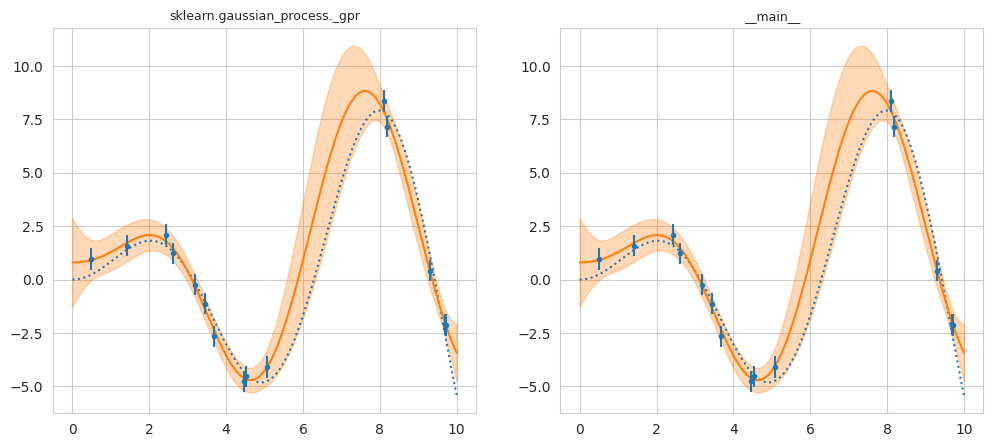

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        kernel = s * ExpSineSquared(l, p)
        gaussian_process = GaussianProcessRegressor(
            kernel=kernel, alpha=noise_std ** 2, n_restarts_optimizer=9
        )
        gaussian_process.fit(X_train, y_train)
        print(gaussian_process.kernel_)
        print(gaussian_process.log_marginal_likelihood_value_)

        print('---')
    else:
        def kernel(s, l, p, x, y):
            return ExpSineSquaredKernel(s, l, p, x, y)


        gaussian_process = GPR(X_train, y_train, kernel, theta_init, eps=noise_std ** 2)
        gaussian_process.fit()

    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    ax.plot(X, y, linestyle="dotted")
    ax.plot(X, mean_prediction, label="Mean prediction")
    ax.errorbar(X_train, y_train, noise_std, linestyle="None", color="tab:blue", marker=".", label="Observations", )
    ax.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.3,
        color="tab:orange",
    )
    ax.set_title(gaussian_process.__module__, fontsize=9)
plt.show()